In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
import lightgbm as lgb
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

In [45]:
# Cargar el dataset procesado que guardamos antes
df = pd.read_csv('../data/processed/df_betania.csv')

In [46]:
df["Reason no cancer-directed surgery"].value_counts()

Reason no cancer-directed surgery
Not recommended                      89901
Surgery performed                    65654
Refused                               2724
Recommended, unknown if performed      429
Name: count, dtype: int64

In [47]:
df.drop(columns=['Race','Sex', 'Combined Summary Stage with Expanded Regional Codes (2004+)',
                 'histology_type_named'], inplace=True)  

In [48]:

# --- DEFINICIÓN DE COLUMNAS (Aquí es donde se declaran) ---
# Usamos las que mencionaste en tus mensajes anteriores
num_features = [
    'age_group', 
    'tumor_category', 
    'grade_clinical', 
    'income_level',
    'Total number of in situ/malignant tumors for patient'
]

cat_features = [
    #'Race',
    #'Rural Code',
    'tratamiento',
   #'Reason no cancer-directed surgery',
   #'Chemotherapy recode (yes, no/unk)',
   #'Radiation recode',
    'Primary Site',
    'Stage_Final',
    #'surgery_class'
]

cortes = [12, 24, 36, 48, 60]
modelos_finales = {}

print("--- ENTRENAMIENTO CON FILTRO DINÁMICO POR HITO ---")

for meses in cortes:
    # 1. FILTRADO ESPECÍFICO PARA ESTE HITO
    condicion_muerte = (df['target_cancer_death'] == 1)
    condicion_vivo_suficiente = (df['target_cancer_death'] == 0) & (df['survival_months_int'] >= meses)
    
    df_hito = df[condicion_muerte | condicion_vivo_suficiente].copy()
    
    # 2. DEFINIR EL TARGET
    target_col = f'target_{meses}_m'
    df_hito[target_col] = np.where(
        (df_hito['target_cancer_death'] == 1) & (df_hito['survival_months_int'] <= meses), 1, 0
    )
    
    # 3. SELECCIÓN DE CARACTERÍSTICAS Y SPLIT
    # Ahora sí, X sabe qué columnas buscar
    X = df_hito[num_features + cat_features]
    y = df_hito[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_features)
    ])

    # 4. PIPELINE (Usando el preprocessor que definiste con OneHot y Scaler)
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor), # Este preprocessor debe estar definido antes
        ('classifier', XGBClassifier(n_estimators=120, learning_rate=0.1, max_depth=5, subsample=0.8, random_state=42))
    ])
    
    # Entrenamiento
    pipeline.fit(X_train, y_train)
    
    # 5. EVALUACIÓN
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    print(f"Hito {meses} meses: Registros={len(df_hito)} | AUC={auc:.4f}")
    
    # Guardar cada pipeline por separado
    joblib.dump(pipeline, f'pipeline_{meses}m.pkl')

print("--- TODOS LOS MODELOS ENTRENADOS Y GUARDADOS ---")

--- ENTRENAMIENTO CON FILTRO DINÁMICO POR HITO ---
Hito 12 meses: Registros=142225 | AUC=0.8779
Hito 24 meses: Registros=132484 | AUC=0.8816
Hito 36 meses: Registros=125316 | AUC=0.8896
Hito 48 meses: Registros=118655 | AUC=0.8919
Hito 60 meses: Registros=112921 | AUC=0.9031
--- TODOS LOS MODELOS ENTRENADOS Y GUARDADOS ---


--- EVALUACIÓN DE MATRICES DE CONFUSIÓN ---


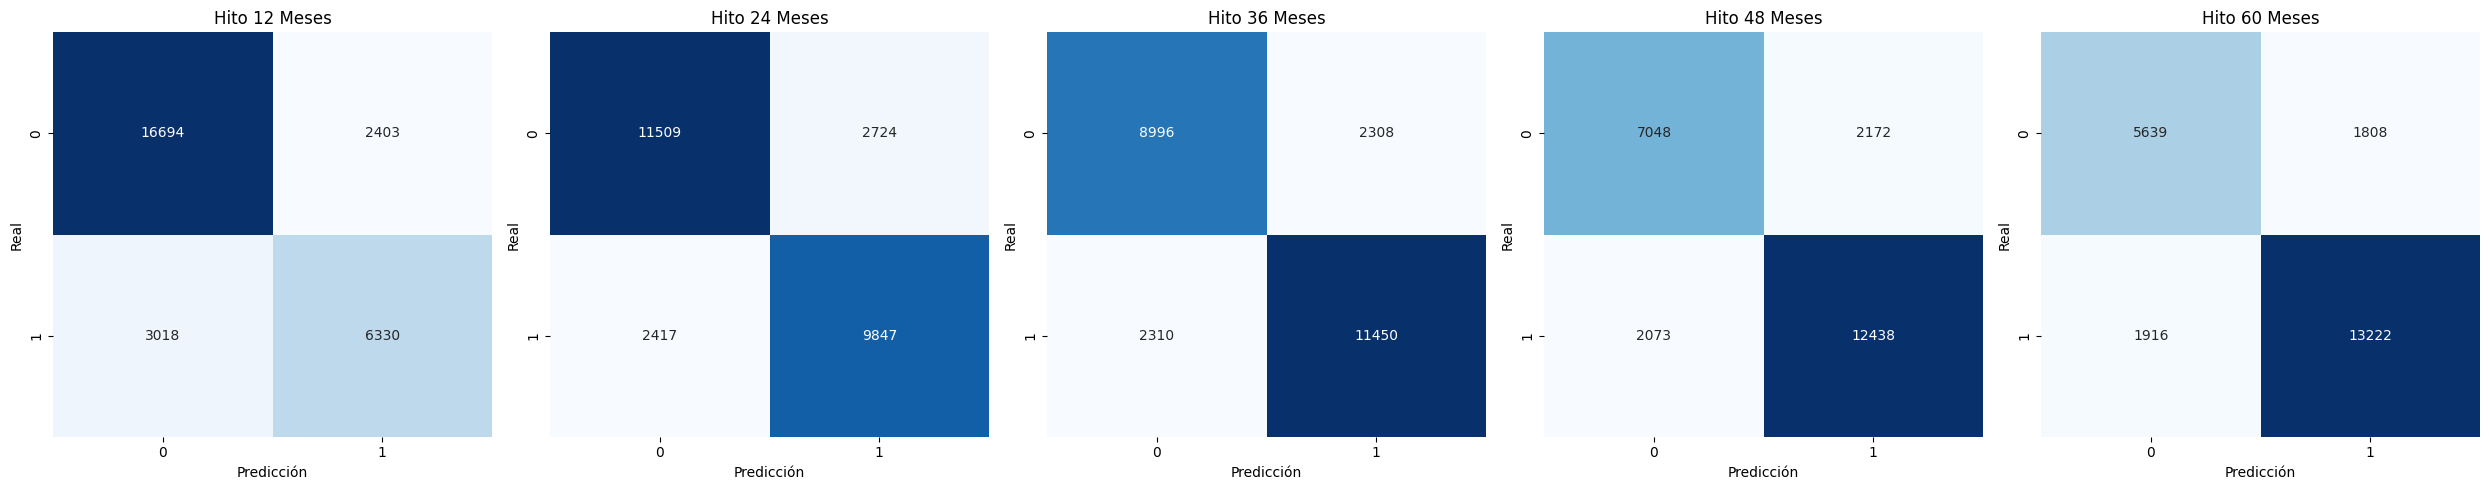


--- PREDICCIÓN PARA PACIENTE NUEVO ---
Riesgo de mortalidad a los 12 meses: 23.3%
Riesgo de mortalidad a los 24 meses: 34.2%
Riesgo de mortalidad a los 36 meses: 55.7%
Riesgo de mortalidad a los 48 meses: 54.9%
Riesgo de mortalidad a los 60 meses: 89.0%


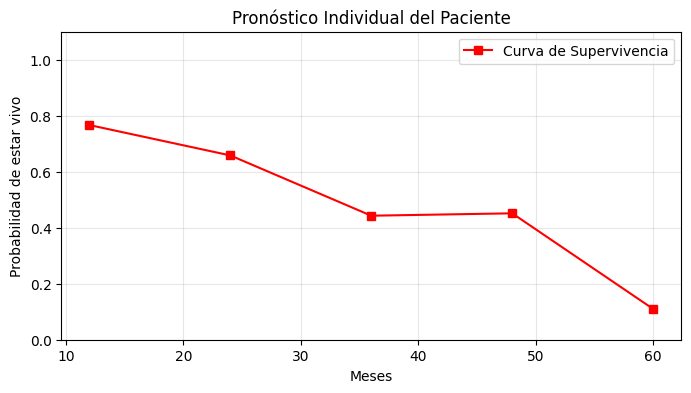

In [49]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# --- PARTE A: EVALUACIÓN (MATRICES DE CONFUSIÓN) ---
cortes = [12, 24, 36, 48, 60]

print("--- EVALUACIÓN DE MATRICES DE CONFUSIÓN ---")
fig, axes = plt.subplots(1, 5, figsize=(25, 5)) # Una fila para los 5 cortes

for i, meses in enumerate(cortes):
    # Cargar el modelo guardado
    pipeline = joblib.load(f'pipeline_{meses}m.pkl')
    
    # 1. Necesitamos los datos de prueba específicos para este hito (df_hito)
    # Repetimos el filtro dinámico solo para obtener X_test e y_test
    condicion_muerte = (df['target_cancer_death'] == 1)
    condicion_vivo_suficiente = (df['target_cancer_death'] == 0) & (df['survival_months_int'] >= meses)
    df_hito = df[condicion_muerte | condicion_vivo_suficiente].copy()
    
    target_col = f'target_{meses}_m'
    df_hito[target_col] = np.where((df_hito['target_cancer_death'] == 1) & (df_hito['survival_months_int'] <= meses), 1, 0)
    
    X = df_hito[num_features + cat_features]
    y = df_hito[target_col]
    _, X_test, _, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # 2. Predecir
    y_pred = pipeline.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    # 3. Graficar Matriz
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap='Blues', cbar=False)
    axes[i].set_title(f"Hito {meses} Meses")
    axes[i].set_xlabel("Predicción")
    axes[i].set_ylabel("Real")

plt.tight_layout()
plt.show()

# --- PARTE B: PREDICCIÓN PACIENTE NUEVO ---
print("\n--- PREDICCIÓN PARA PACIENTE NUEVO ---")

# Define aquí los valores de tu paciente (asegúrate que los nombres coincidan)
nuevo_paciente = {
    'age_group': 20,
    'tumor_category': 10.0, # mm
    'grade_clinical': 1,
    'income_level': 5,
    'Total number of in situ/malignant tumors for patient': 1,
    'Rural Code': 'Counties in metropolitan areas ge 1 million pop',
    'tratamiento': 'S + Q + nR',
    'Reason no cancer-directed surgery': 'Surgery performed',
    'Primary Site': 'C34.3-Lower lobe, lung',
    'Stage_Final': 4
}

df_nuevo = pd.DataFrame([nuevo_paciente])
probabilidades = []

for meses in cortes:
    pipeline = joblib.load(f'pipeline_{meses}m.pkl')
    prob_muerte = pipeline.predict_proba(df_nuevo)[0][1]
    probabilidades.append(prob_muerte)
    print(f"Riesgo de mortalidad a los {meses} meses: {prob_muerte:.1%}")

# Graficar la curva resultante para el paciente
supervivencia = [1 - p for p in probabilidades]
plt.figure(figsize=(8, 4))
plt.plot(cortes, supervivencia, marker='s', color='red', label='Curva de Supervivencia')
plt.ylim(0, 1.1)
plt.title("Pronóstico Individual del Paciente")
plt.xlabel("Meses")
plt.ylabel("Probabilidad de estar vivo")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


--- PREDICCIÓN PARA PACIENTE NUEVO ---
Riesgo de mortalidad a los 12 meses: 33.9%
Riesgo de mortalidad a los 24 meses: 59.4%
Riesgo de mortalidad a los 36 meses: 68.1%
Riesgo de mortalidad a los 48 meses: 70.9%
Riesgo de mortalidad a los 60 meses: 79.2%


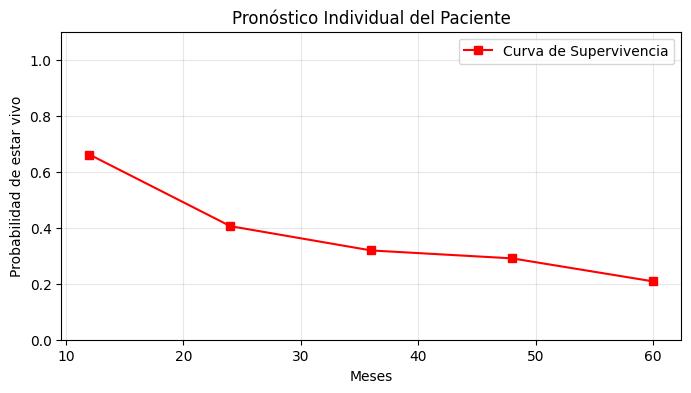

In [50]:
for i, meses in enumerate(cortes):
    # Cargar el modelo guardado
    pipeline = joblib.load(f'pipeline_{meses}m.pkl')
    
   

# --- PARTE B: PREDICCIÓN PACIENTE NUEVO ---
print("\n--- PREDICCIÓN PARA PACIENTE NUEVO ---")

# Define aquí los valores de tu paciente (asegúrate que los nombres coincidan)
nuevo_paciente = {
    'age_group': 5,
    'tumor_category': 60.0, # mm
    'grade_clinical': 4,
    'income_level': 5,
    'Total number of in situ/malignant tumors for patient': 1,
    'Rural Code': 'Counties in metropolitan areas ge 1 million pop',
    'tratamiento': 'S + Q + nR',
    'Reason no cancer-directed surgery': 'Surgery performed',
    'Primary Site': 'C34.3-Lower lobe, lung',
    'Stage_Final': 4
}

df_nuevo = pd.DataFrame([nuevo_paciente])
probabilidades = []

for meses in cortes:
    pipeline = joblib.load(f'pipeline_{meses}m.pkl')
    prob_muerte = pipeline.predict_proba(df_nuevo)[0][1]
    probabilidades.append(prob_muerte)
    print(f"Riesgo de mortalidad a los {meses} meses: {prob_muerte:.1%}")

# Graficar la curva resultante para el paciente
supervivencia = [1 - p for p in probabilidades]
plt.figure(figsize=(8, 4))
plt.plot(cortes, supervivencia, marker='s', color='red', label='Curva de Supervivencia')
plt.ylim(0, 1.1)
plt.title("Pronóstico Individual del Paciente")
plt.xlabel("Meses")
plt.ylabel("Probabilidad de estar vivo")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()